## 1. Importacion de librerias

In [1]:
import torch
print(torch.__version__)


2.9.1


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import gc

# Importar AMP (compatible con PyTorch 1.x y 2.x)
try:
    from torch.amp import autocast, GradScaler
    AMP_DEVICE = 'cuda'  # PyTorch 2.x requiere especificar device
except ImportError:
    from torch.cuda.amp import autocast, GradScaler
    AMP_DEVICE = None  # PyTorch 1.x no requiere device

# Importar utilidades compartidas entre notebooks
from utils import (
    load_data,
    split_data_by_weeks,
    evaluate_model,
    save_metrics,
    plot_all_diagnostics,
    FEATURE_COLS,
    TARGETS,
    HORIZONS
)

# Configurar estilo de graficas
plt.style.use('seaborn-v0_8-notebook')

# Configuracion de directorios
OUTPUT_DIR = 'output/3_lstm'
MODEL_NAME = 'LSTM'

# Crear directorio de salida si no existe
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


In [3]:
def get_device():
    """
    Selecciona el mejor dispositivo disponible para entrenamiento.
    
    Prioridad:
    1. CUDA para GPUs NVIDIA
    2. MPS para Apple Silicon (M1/M2/M3)
    3. CPU como fallback
    
    Returns
    -------
    torch.device
        Dispositivo configurado
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        device_name = torch.cuda.get_device_name(0)
        print(f"Dispositivo: CUDA ({device_name})")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
        print(f"Dispositivo: MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print(f"Dispositivo: CPU")
    return device

device = get_device()


Dispositivo: MPS (Apple Silicon)


## 2. Configuracion de hiperparametros

Los hiperparametros se ajustan automaticamente segun el hardware disponible para optimizar el uso de recursos y tiempo de entrenamiento.

In [ ]:
def get_hyperparameters(device):
    """
    Ajusta hiperparametros segun el dispositivo detectado.
    
    Configura batch size, arquitectura del modelo y parametros de entrenamiento
    optimizados para cada tipo de hardware (GPU NVIDIA, Apple Silicon, CPU).
    
    Parameters
    ----------
    device : torch.device
        Dispositivo donde se ejecutara el entrenamiento
    
    Returns
    -------
    dict
        Diccionario con hiperparametros configurados
    """
    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        print(f"GPU detectada: {gpu_name}")
        print(f"Memoria GPU: {gpu_memory_gb:.1f} GB")
        
        if 'A100' in gpu_name or gpu_memory_gb > 30:
            print("Configuracion: GPU de alto rendimiento")
            return {
                'sequence_length': 24,
                'hidden_size': 256,
                'num_layers': 3,
                'dropout': 0.3,
                'batch_size': 2048,
                'learning_rate': 0.001,
                'num_epochs': 100,
                'early_stopping_patience': 15,
                'sample_stations': None,
                'use_amp': True,
                'gradient_accumulation_steps': 1,
                'pin_memory': True,
                'total_weeks': 30,
                'train_weeks': 22,
                'val_weeks': 4,
                'test_weeks': 4
            }
        else:
            print("Configuracion: GPU estandar")
            return {
                'sequence_length': 12,
                'hidden_size': 128,
                'num_layers': 2,
                'dropout': 0.2,
                'batch_size': 1024,
                'learning_rate': 0.001,
                'num_epochs': 100,
                'early_stopping_patience': 15,
                'sample_stations': None,
                'use_amp': True,
                'gradient_accumulation_steps': 2,
                'pin_memory': True,
                'total_weeks': 30,
                'train_weeks': 22,
                'val_weeks': 4,
                'test_weeks': 4
            }
    
    elif device.type == 'mps':
        print("Configuracion: Apple Silicon (MPS)")
        return {
            'sequence_length': 12,
            'hidden_size': 64,
            'num_layers': 2,
            'dropout': 0.3,
            'batch_size': 2048,
            'learning_rate': 0.001,
            'num_epochs': 50,
            'early_stopping_patience': 10,
            'sample_stations': None,
            'use_amp': False,
            'gradient_accumulation_steps': 2,
            'pin_memory': False,
            'total_weeks': 16,
            'train_weeks': 12,
            'val_weeks': 2,
            'test_weeks': 2
        }
    
    else:
        print("Configuracion: CPU (modo conservador)")
        return {
            'sequence_length': 6,
            'hidden_size': 32,
            'num_layers': 1,
            'dropout': 0.1,
            'batch_size': 64,
            'learning_rate': 0.001,
            'num_epochs': 30,
            'early_stopping_patience': 8,
            'sample_stations': 100,
            'use_amp': False,
            'gradient_accumulation_steps': 1,
            'pin_memory': False,
            'total_weeks': 12,
            'train_weeks': 8,
            'val_weeks': 2,
            'test_weeks': 2
        }

hyperparams = get_hyperparameters(device)

SEQUENCE_LENGTH = hyperparams['sequence_length']
HIDDEN_SIZE = hyperparams['hidden_size']
NUM_LAYERS = hyperparams['num_layers']
DROPOUT = hyperparams['dropout']
BATCH_SIZE = hyperparams['batch_size']
LEARNING_RATE = hyperparams['learning_rate']
NUM_EPOCHS = hyperparams['num_epochs']
EARLY_STOPPING_PATIENCE = hyperparams['early_stopping_patience']
SAMPLE_STATIONS = hyperparams.get('sample_stations', None)

TOTAL_WEEKS = hyperparams['total_weeks']
TRAIN_WEEKS = hyperparams['train_weeks']
VAL_WEEKS = hyperparams['val_weeks']
TEST_WEEKS = hyperparams['test_weeks']


Configuracion: Apple Silicon (MPS) - modo optimizado

Hiperparametros del modelo LSTM:
  Longitud de secuencia: 12 (120 min)
  Hidden size: 64
  Num layers: 2
  Dropout: 0.3
  Batch size: 2048
  Learning rate: 0.001
  Max epochs: 50
  Early stopping patience: 10

Split de datos:
  Total semanas: 16
  Train: 12 semanas
  Validacion: 2 semanas
  Test: 2 semanas

Optimizaciones de memoria:
  Mixed Precision (AMP): False
  Gradient Accumulation Steps: 2
  Pin Memory: False


## 3. Carga de datos

In [ ]:
# Cargar dataset completo
df = load_data()


Datos cargados: 20,436,599 registros
Estaciones: 677
Periodo: 2025-05-02 00:00:00-06:00 a 2025-11-30 22:50:00-06:00
Features incluyen lags y trends precalculados: ocu_lag_1,2,6,12,138,144 y ocu_trend_1,2,6,12
Verificacion: No hay valores NaN en features ni targets


In [ ]:
# Dividir datos por semanas segun configuracion del hardware
train_df, val_df, test_df = split_data_by_weeks(
    df, 
    total_weeks=TOTAL_WEEKS,
    train_weeks=TRAIN_WEEKS, 
    val_weeks=VAL_WEEKS, 
    test_weeks=TEST_WEEKS
)


Total de semanas disponibles en el dataset: 31
Zona horaria utilizada: America/Mexico_City
Primera semana: 2025-W18
Ultima semana: 2025-W48

Semanas eliminadas del inicio: 15
  Primera semana eliminada: 2025-W18
  Ultima semana eliminada: 2025-W32

Semanas a utilizar: 16 (de 2025-W33 a 2025-W48)

Semanas asignadas:
  Train: 2025-W33 a 2025-W44 (12 semanas)
  Val:   2025-W45 a 2025-W46 (2 semanas)
  Test:  2025-W47 a 2025-W48 (2 semanas)

Division de datos:
  Entrenamiento: 8,005,525 registros (12 semanas)
  Validacion:    1,364,832 registros (2 semanas)
  Pruebas:       1,313,380 registros (2 semanas)

Rangos de fechas:
  Train: 2025-08-11 00:00:00-06:00 a 2025-11-02 23:50:00-06:00
  Val:   2025-11-03 00:00:00-06:00 a 2025-11-16 23:50:00-06:00
  Test:  2025-11-17 00:00:00-06:00 a 2025-11-30 22:50:00-06:00


## 4. Preparacion de datos

In [ ]:
# Crear y ajustar scaler solo con datos de entrenamiento
scaler = StandardScaler()

X_train = train_df[FEATURE_COLS].values
X_val = val_df[FEATURE_COLS].values
X_test = test_df[FEATURE_COLS].values

# Aplicar escalado (LSTM requiere features normalizadas)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Escalado completado usando StandardScaler ajustado solo con train")
print(f"Features: {len(FEATURE_COLS)}")

# Guardar scaler para uso posterior
joblib.dump(scaler, f'{OUTPUT_DIR}/scaler.pkl')
print(f"Scaler guardado en: {OUTPUT_DIR}/scaler.pkl")


Escalado completado (ajustado solo con train)
Features: 42
Scaler guardado en: output/3_lstm/scaler.pkl


In [ ]:
def create_sequences(df, X_scaled, sequence_length, targets, sample_stations=None):
    """
    Crea secuencias temporales para entrenamiento de LSTM.
    
    Agrupa los datos por estacion para mantener la continuidad temporal
    y genera secuencias de longitud fija con sus correspondientes targets.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame con los datos originales
    X_scaled : np.ndarray
        Features escaladas
    sequence_length : int
        Longitud de cada secuencia temporal
    targets : list
        Lista de nombres de columnas target
    sample_stations : int, optional
        Numero de estaciones a muestrear para reducir uso de memoria
        
    Returns
    -------
    tuple
        (X_sequences, y_dict, indices) donde:
        - X_sequences: array de secuencias (n_samples, seq_length, n_features)
        - y_dict: diccionario con targets para cada horizonte
        - indices: indices originales de cada secuencia en el DataFrame
    """
    sequences = []
    targets_dict = {target: [] for target in targets}
    indices = []
    
    stations = df['station_code'].unique()
    
    if sample_stations is not None and sample_stations < len(stations):
        np.random.seed(42)
        stations = np.random.choice(stations, size=sample_stations, replace=False)
        print(f"  Muestreando {sample_stations} de {len(df['station_code'].unique())} estaciones")
    
    for station in tqdm(stations, desc="Creando secuencias"):
        mask = df['station_code'] == station
        station_indices = np.where(mask)[0]
        
        if len(station_indices) < sequence_length + 1:
            continue
        
        station_X = X_scaled[station_indices]
        station_df = df.iloc[station_indices]
        
        for i in range(sequence_length, len(station_indices)):
            seq = station_X[i-sequence_length:i]
            sequences.append(seq)
            
            for target in targets:
                targets_dict[target].append(station_df[target].iloc[i])
            
            indices.append(station_indices[i])
    
    X_seq = np.array(sequences)
    y_dict = {target: np.array(targets_dict[target]) for target in targets}
    
    return X_seq, y_dict, np.array(indices)


In [9]:
import gc

# Crear secuencias temporales para cada conjunto de datos
print("Creando secuencias para entrenamiento...")
X_train_seq, y_train_dict, train_indices = create_sequences(
    train_df.reset_index(drop=True), X_train_scaled, SEQUENCE_LENGTH, TARGETS, SAMPLE_STATIONS
)
del X_train_scaled
gc.collect()

print("\nCreando secuencias para validacion...")
X_val_seq, y_val_dict, val_indices = create_sequences(
    val_df.reset_index(drop=True), X_val_scaled, SEQUENCE_LENGTH, TARGETS, SAMPLE_STATIONS
)
del X_val_scaled
gc.collect()

print("\nCreando secuencias para test...")
X_test_seq, y_test_dict, test_indices = create_sequences(
    test_df.reset_index(drop=True), X_test_scaled, SEQUENCE_LENGTH, TARGETS, SAMPLE_STATIONS
)
del X_test_scaled
gc.collect()

print(f"\nDimensiones de secuencias:")
print(f"  Train: {X_train_seq.shape}")
print(f"  Val:   {X_val_seq.shape}")
print(f"  Test:  {X_test_seq.shape}")


Creando secuencias para entrenamiento...


Creando secuencias: 100%|██████████| 677/677 [04:13<00:00,  2.67it/s]



Creando secuencias para validacion...


Creando secuencias: 100%|██████████| 677/677 [00:45<00:00, 14.97it/s]



Creando secuencias para test...


Creando secuencias: 100%|██████████| 677/677 [00:43<00:00, 15.55it/s]



Dimensiones de secuencias:
  Train: (7997401, 12, 42)
  Val:   (1356708, 12, 42)
  Test:  (1305256, 12, 42)


## 5. Dataset y DataLoader de PyTorch

In [ ]:
class SequenceDataset(Dataset):
    """
    Dataset de PyTorch para secuencias temporales.
    
    Optimizado para eficiencia de memoria al convertir los datos
    a tensores una sola vez y liberar los arrays numpy originales.
    """
    def __init__(self, X, y_dict, device_type='cpu'):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(
            np.stack([y_dict[target] for target in TARGETS], axis=1)
        ).float()
        
        del X
        for key in list(y_dict.keys()):
            del y_dict[key]
        gc.collect()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [11]:
# Crear datasets de PyTorch y liberar memoria
print("Creando datasets de PyTorch...")
train_dataset = SequenceDataset(X_train_seq, y_train_dict, device.type)
del X_train_seq
gc.collect()

val_dataset = SequenceDataset(X_val_seq, y_val_dict, device.type)
del X_val_seq
gc.collect()

test_dataset = SequenceDataset(X_test_seq, y_test_dict, device.type)
del X_test_seq
gc.collect()

# Configurar numero de workers segun hardware
num_workers = 4 if device.type == 'cuda' else 0

# Crear DataLoaders para entrenamiento
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=num_workers,
    pin_memory=hyperparams['pin_memory']
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=hyperparams['pin_memory']
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=num_workers,
    pin_memory=hyperparams['pin_memory']
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Workers: {num_workers}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Creando datasets de PyTorch...
Train batches: 3905
Val batches: 663
Test batches: 638
num_workers: 0, pin_memory: False


## 6. Definicion del modelo LSTM

In [ ]:
class LSTMModel(nn.Module):
    """
    Red neuronal LSTM para prediccion multi-horizonte de deltas de ocupacion.
    
    Arquitectura:
    - Capas LSTM recurrentes con dropout
    - Capas fully connected para transformar la salida
    - Prediccion simultanea de los tres horizontes temporales
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_output = lstm_out[:, -1, :]
        
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


In [13]:
# Crear modelo LSTM con configuracion segun hardware
input_size = len(FEATURE_COLS)
output_size = len(TARGETS)

model = LSTMModel(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=output_size,
    dropout=DROPOUT
).to(device)

print(model)
print(f"\nParametros totales: {sum(p.numel() for p in model.parameters()):,}")


LSTMModel(
  (lstm): LSTM(42, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

Parametros totales: 63,107


## 7. Entrenamiento

In [14]:
# Configurar optimizador, scheduler y GradScaler para entrenamiento
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Configurar AMP segun version de PyTorch
if AMP_DEVICE:
    scaler = GradScaler(AMP_DEVICE, enabled=USE_AMP and device.type == 'cuda')
else:
    scaler = GradScaler(enabled=USE_AMP and device.type == 'cuda')
print(f"GradScaler habilitado: {USE_AMP and device.type == 'cuda'}")


GradScaler habilitado: False


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, scaler, use_amp, accum_steps):
    """
    Entrena una epoca del modelo con soporte para optimizaciones de hardware.
    
    Implementa:
    - Mixed Precision Training (AMP) para GPUs NVIDIA
    - Gradient Accumulation para simular batch sizes mas grandes
    - Gradient Clipping para estabilidad del entrenamiento
    
    Parameters
    ----------
    model : nn.Module
        Modelo a entrenar
    loader : DataLoader
        DataLoader con los datos de entrenamiento
    criterion : nn.Module
        Funcion de perdida
    optimizer : torch.optim.Optimizer
        Optimizador
    device : torch.device
        Dispositivo de computo
    scaler : GradScaler
        Scaler para mixed precision
    use_amp : bool
        Si usar mixed precision training
    accum_steps : int
        Numero de pasos para gradient accumulation
    
    Returns
    -------
    float
        Perdida promedio de la epoca
    """
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for batch_idx, (X_batch, y_batch) in enumerate(loader):
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        
        amp_enabled = use_amp and device.type == 'cuda'
        ctx = autocast(AMP_DEVICE, enabled=amp_enabled) if AMP_DEVICE else autocast(enabled=amp_enabled)
        with ctx:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss = loss / accum_steps
        
        if use_amp and device.type == 'cuda':
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1) == len(loader):
            if use_amp and device.type == 'cuda':
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            optimizer.zero_grad()
        
        total_loss += (loss.item() * accum_steps) * len(X_batch)
    
    return total_loss / len(loader.dataset)


def evaluate(model, loader, criterion, device, use_amp):
    """
    Evalua el modelo en un conjunto de datos.
    
    Parameters
    ----------
    model : nn.Module
        Modelo a evaluar
    loader : DataLoader
        DataLoader con los datos de evaluacion
    criterion : nn.Module
        Funcion de perdida
    device : torch.device
        Dispositivo de computo
    use_amp : bool
        Si usar mixed precision
    
    Returns
    -------
    float
        Perdida promedio
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            amp_enabled = use_amp and device.type == 'cuda'
            ctx = autocast(AMP_DEVICE, enabled=amp_enabled) if AMP_DEVICE else autocast(enabled=amp_enabled)
            with ctx:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * len(X_batch)
    
    return total_loss / len(loader.dataset)


In [ ]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("Iniciando entrenamiento...")
print(f"  Mixed Precision: {USE_AMP and device.type == 'cuda'}")
print(f"  Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  Batch size efectivo: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}\n")

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(
        model, train_loader, criterion, optimizer, device,
        scaler, USE_AMP, GRADIENT_ACCUMULATION_STEPS
    )
    val_loss = evaluate(model, val_loader, criterion, device, USE_AMP)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, f'{OUTPUT_DIR}/best_model.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6f} | Best: {best_val_loss:.6f}")
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping en epoca {epoch+1}")
        break

print(f"\nEntrenamiento completado. Mejor Val Loss: {best_val_loss:.6f}")


Iniciando entrenamiento...
  Mixed Precision: False
  Gradient Accumulation Steps: 2
  Batch size efectivo: 4096

Epoch   5 | Train Loss: 0.009350 | Val Loss: 0.009891 | LR: 0.001000 | Best: 0.009891
Epoch  10 | Train Loss: 0.009227 | Val Loss: 0.009922 | LR: 0.001000 | Best: 0.009891
Epoch  15 | Train Loss: 0.009129 | Val Loss: 0.009935 | LR: 0.000500 | Best: 0.009891

Early stopping en epoca 15

Entrenamiento completado. Mejor Val Loss: 0.009891


## 8. Curvas de entrenamiento

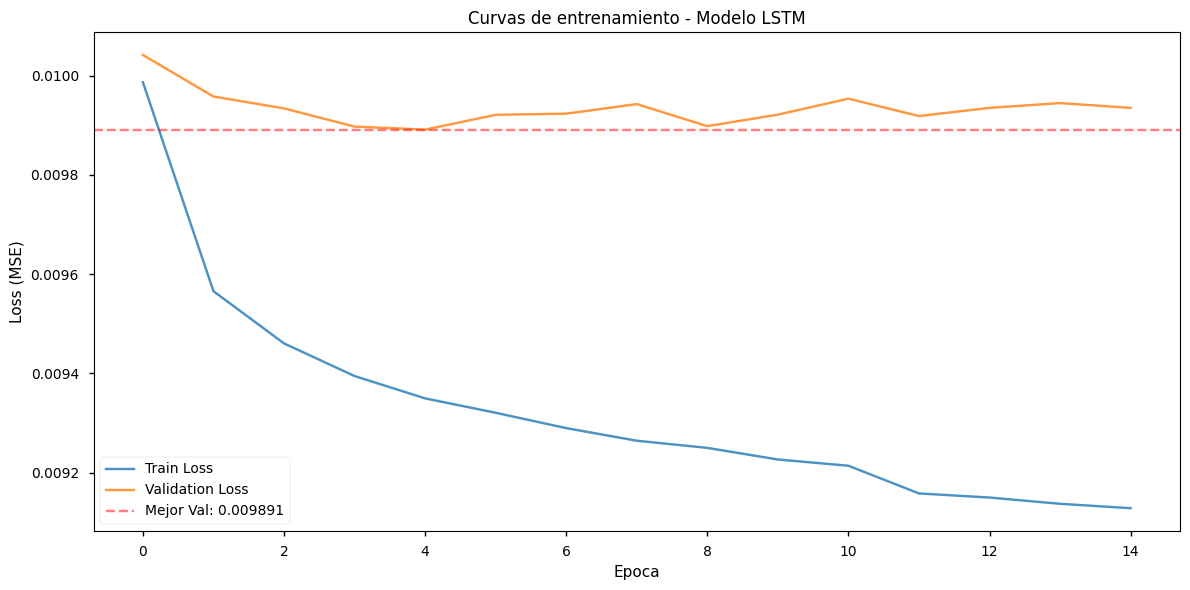

In [17]:
# Graficar curvas de perdida
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_losses, label='Train Loss', alpha=0.8)
ax.plot(val_losses, label='Validation Loss', alpha=0.8)
ax.axhline(y=best_val_loss, color='r', linestyle='--', alpha=0.5, 
           label=f'Mejor Val: {best_val_loss:.6f}')

ax.set_xlabel('Epoca')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Curvas de entrenamiento - Modelo LSTM')
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Evaluacion en conjunto de pruebas

In [ ]:
# Cargar mejor modelo guardado durante el entrenamiento
checkpoint = torch.load(f'{OUTPUT_DIR}/best_model.pt', map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Modelo cargado de epoca {checkpoint['epoch']+1}")


Modelo cargado de epoca 5


In [ ]:
# Generar predicciones para el conjunto de pruebas
model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_preds.append(outputs.cpu().numpy())

predictions = np.concatenate(all_preds, axis=0)
print(f"Predicciones shape: {predictions.shape}")


Predicciones shape: (1305256, 3)


In [ ]:
# Organizar predicciones y valores reales por horizonte
y_true_all = test_dataset.y.cpu().numpy()

y_true_dict = {}
y_pred_dict = {}

for i, target in enumerate(TARGETS):
    y_true_dict[target] = y_true_all[:, i]
    y_pred_dict[target] = predictions[:, i]

print(f"Registros en test (secuencias): {len(predictions):,}")


Registros en test (secuencias): 1,305,256


In [ ]:
import pickle

# Cargar MAE del modelo baseline para calcular Skill Score
baseline_file = 'output/0_persistence/baseline_mae.pkl'
with open(baseline_file, 'rb') as f:
    baseline_mae_dict = pickle.load(f)

print(f"Baseline MAE cargado desde: {baseline_file}")

# Evaluar el modelo y calcular metricas
capacity = test_df.reset_index(drop=True).iloc[test_indices]['capacity'].values
metrics_df = evaluate_model(y_true_dict, y_pred_dict, capacity=capacity, baseline_mae_dict=baseline_mae_dict)

print("\nMetricas en conjunto de pruebas:")
print("=" * 70)
print(metrics_df.to_string(index=False))
print("=" * 70)
print("\nMAE_bikes: error promedio en numero de bicicletas")
print("SS (Skill Score): mejora respecto al baseline (0=igual, >0=mejor, <0=peor)")


Baseline MAE cargado desde: output/0_persistence/baseline_mae.pkl

Metricas en conjunto de pruebas:
 Horizonte      MAE     RMSE  MAE_bikes        SS
        20 0.042205 0.074216   1.092403 -0.016696
        40 0.059668 0.098452   1.548280  0.045735
        60 0.071568 0.114478   1.860643  0.087056

Nota: MAE_bikes es el error promedio en numero de bicicletas
      SS (Skill Score) mide mejora respecto al baseline (0=igual, >0=mejor, <0=peor)


In [ ]:
# Guardar metricas en archivo CSV
save_metrics(metrics_df, OUTPUT_DIR)


Metricas guardadas en: output/3_lstm/metrics.csv


## 10. Visualizacion de resultados

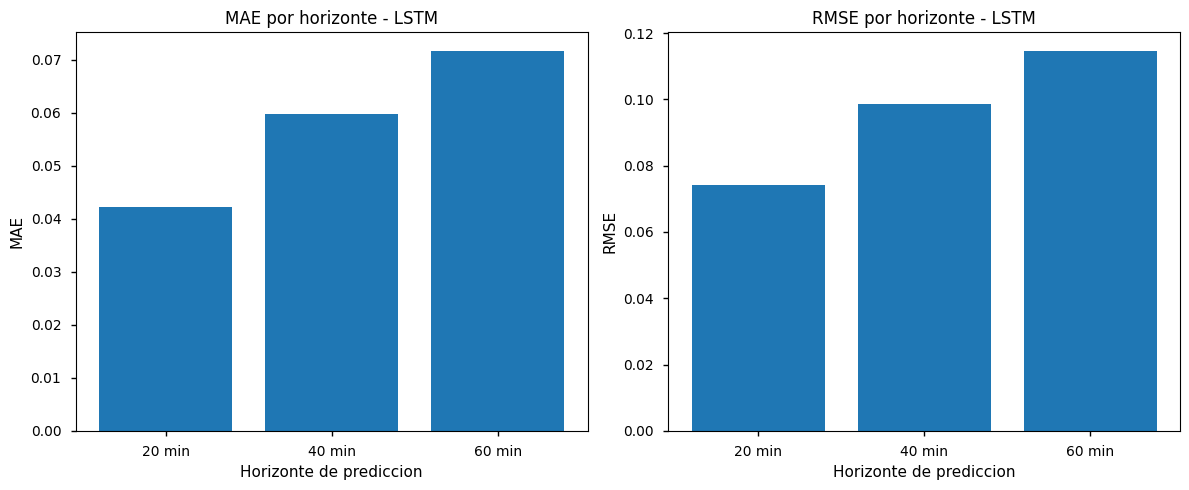

In [ ]:
# Generar graficos de MAE y RMSE por horizonte temporal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MAE por horizonte
axes[0].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['MAE'])
axes[0].set_xlabel('Horizonte de prediccion')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE por horizonte - LSTM')

# RMSE por horizonte
axes[1].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['RMSE'])
axes[1].set_xlabel('Horizonte de prediccion')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE por horizonte - LSTM')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()


## 11. Graficas de diagnostico

In [ ]:
# Crear subset de test_df con solo las secuencias generadas
test_df_seq = test_df.reset_index(drop=True).iloc[test_indices].copy()

print(f"Registros en test_df_seq: {len(test_df_seq):,}")


Registros en test_df_seq: 1,305,256


In [ ]:
# Generar graficas de diagnostico (residuos, predicho vs real, etc)
print("Generando graficas de diagnostico...")
plot_all_diagnostics(
    df_test=test_df_seq,
    y_true_dict=y_true_dict,
    y_pred_dict=y_pred_dict,
    output_dir=OUTPUT_DIR,
    model_name=MODEL_NAME
)


Generando graficas de diagnostico...
  Estaciones seleccionadas:
    Alta actividad: 007
    Baja actividad: 443
    Actividad media: 107-108
  Generando graficas para horizonte 20 min...
  Generando graficas para horizonte 40 min...
  Generando graficas para horizonte 60 min...
Graficas guardadas en: output/3_lstm


## 12. Guardar configuracion del modelo

In [ ]:
# Guardar configuracion del modelo para uso posterior
config = {
    'sequence_length': SEQUENCE_LENGTH,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
    'input_size': input_size,
    'output_size': output_size,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'best_epoch': checkpoint['epoch'] + 1,
    'best_val_loss': best_val_loss,
    'feature_cols': FEATURE_COLS,
    'targets': TARGETS
}

joblib.dump(config, f'{OUTPUT_DIR}/model_config.pkl')
print(f"Configuracion guardada en: {OUTPUT_DIR}/model_config.pkl")


Configuracion guardada en: output/3_lstm/model_config.pkl


## 13. Resumen

In [ ]:
# Mostrar resumen de configuracion y resultados del modelo
print("=" * 60)
print("RESUMEN - MODELO LSTM")
print("=" * 60)
print(f"\nArquitectura:")
print(f"  Longitud secuencia: {SEQUENCE_LENGTH} ({SEQUENCE_LENGTH * 10} min)")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Parametros: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nEntrenamiento:")
print(f"  Mejor epoca: {checkpoint['epoch']+1}")
print(f"  Mejor val loss: {best_val_loss:.6f}")
print(f"  Dispositivo: {device}")
print(f"\nConjuntos de datos (secuencias):")
print(f"  Entrenamiento: {len(train_dataset):,}")
print(f"  Validacion:    {len(val_dataset):,}")
print(f"  Pruebas:       {len(test_dataset):,}")
print(f"\nMetricas en conjunto de pruebas:")
for _, row in metrics_df.iterrows():
    print(f"  Horizonte {int(row['Horizonte'])} min: MAE={row['MAE']:.6f}, RMSE={row['RMSE']:.6f}, MAE_bikes={row['MAE_bikes']:.2f}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}")
print("=" * 60)


RESUMEN - MODELO LSTM

Arquitectura:
  Longitud secuencia: 12 (120 min)
  Hidden size: 64
  Num layers: 2
  Dropout: 0.3
  Parametros: 63,107

Entrenamiento:
  Mejor epoca: 5
  Mejor val loss: 0.009891
  Dispositivo: mps

Conjuntos de datos (secuencias):
  Entrenamiento: 7,997,401
  Validacion:    1,356,708
  Pruebas:       1,305,256

Metricas en conjunto de pruebas:
  Horizonte 20 min: MAE=0.042205, RMSE=0.074216, MAE_bikes=1.09
  Horizonte 40 min: MAE=0.059668, RMSE=0.098452, MAE_bikes=1.55
  Horizonte 60 min: MAE=0.071568, RMSE=0.114478, MAE_bikes=1.86

Archivos guardados en: output/3_lstm
